<a href="https://colab.research.google.com/github/carlosherediapimienta/AutoEncoders_pytorch/blob/main/Fraud_Detection_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
import warnings
warnings.filterwarnings('ignore')

#1. File reading (Keagle - Data)

In [167]:
import pandas as pd
df = pd.read_csv('/content/creditcard.csv')

## 1.1 Data Manipulation

In [168]:
df.columns = map(str.lower, df.columns) # All letters in Lower case
df.rename(columns={'class': 'label'}, inplace=True) # Redefining class column

## 1.2 Setting Random Seeds:

In [169]:
import torch
import numpy as np
import random as rn

RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
  torch.cuda.manual_seed(RANDOM_SEED) #Random number in CUDA
  torch.cuda.manual_seed_all(RANDOM_SEED) #All Random numbers in CUDA

##1.3 Rescale the column Amount with Log10

In [170]:
# We add a small number to avoid 0!
df['log10_amount'] = np.log10(df.amount + 0.00001)

## 1.4 Splitting Data

In [171]:
RATIO_TO_FRAUD = 15

df = df.drop(['time', 'amount'], axis=1)

# We split the data by the column Label
fraud = df[df.label == 1]
clean = df[df.label == 0]

# We reduce the sample of the clean data to fit
# with the lenght of data fraud.
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# We isolate features from labels
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [13]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 284,315 to 7,380.
This represents a ratio of 15:1 to fraud.


# 2. Clustering - TSNE Method:

In [14]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d\
        (What are you?An alien that can visualise >3d?). Make sure the\
        "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction (method)
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED)
    features_embedded = features_embedded.fit_transform(features)

    # Initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))

    # Counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # Plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=3,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=3,
        alpha=0.3,
        label='Clean'
    )

    plt.legend(loc='best')
    plt.show;

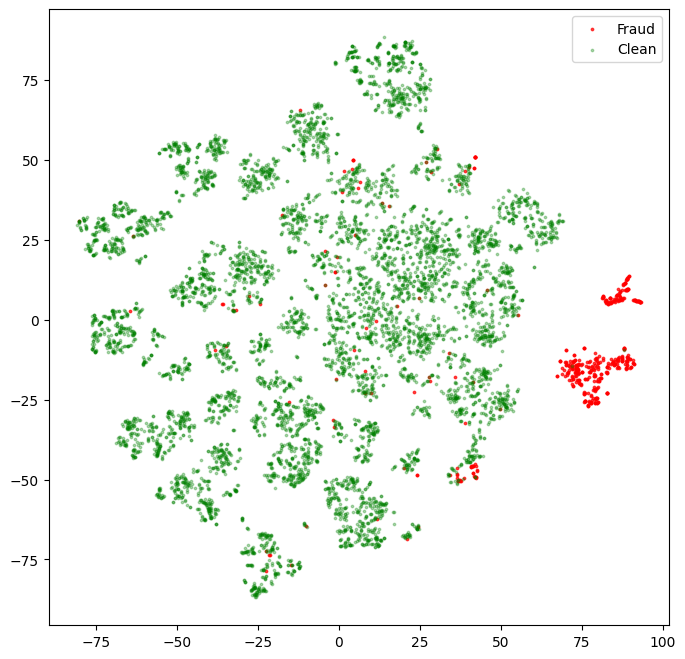

In [164]:
tsne_scatter(features, labels, dimensions=2)

#3. Training and Testing Data

In [174]:
# We take all the clean data
clean = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# testing  set: the remaining non-fraud + all the fraud
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

print(f"""Our testing set is composed as follows:
{X_test.label.value_counts()}""")

Our testing set is composed as follows:
0    84315
1      492
Name: label, dtype: int64


## 3.1 Training and Validation dataset

In [175]:
from sklearn.model_selection import train_test_split

# train // validate - We don't need labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train,
                                       test_size=VALIDATE_SIZE,
                                       random_state=RANDOM_SEED)

# We manually split the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [176]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


#4. Pipeline to normalize and scale data

In [22]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# Pipeline configuration:
pipeline = Pipeline([('normalizer', Normalizer()),('scaler', MinMaxScaler())])

In [23]:
# Pipeline application:
pipeline.fit(X_train) #We fit the pipeline with the x_train
X_train_transformed = pipeline.transform(X_train) # We apply it
X_validate_transformed = pipeline.transform(X_validate)

##4.1 Graph Before and After Pipeline

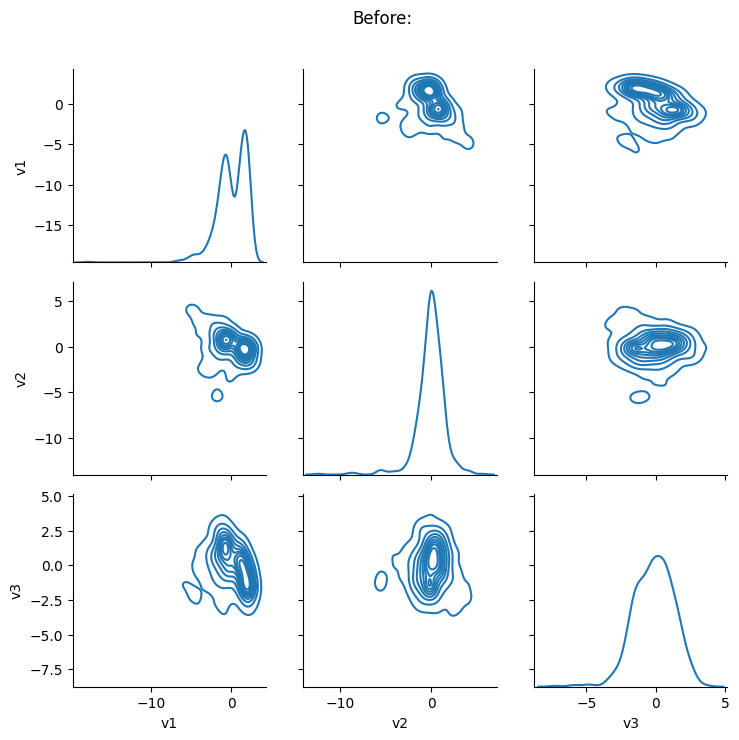

In [25]:
import seaborn as sns

g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

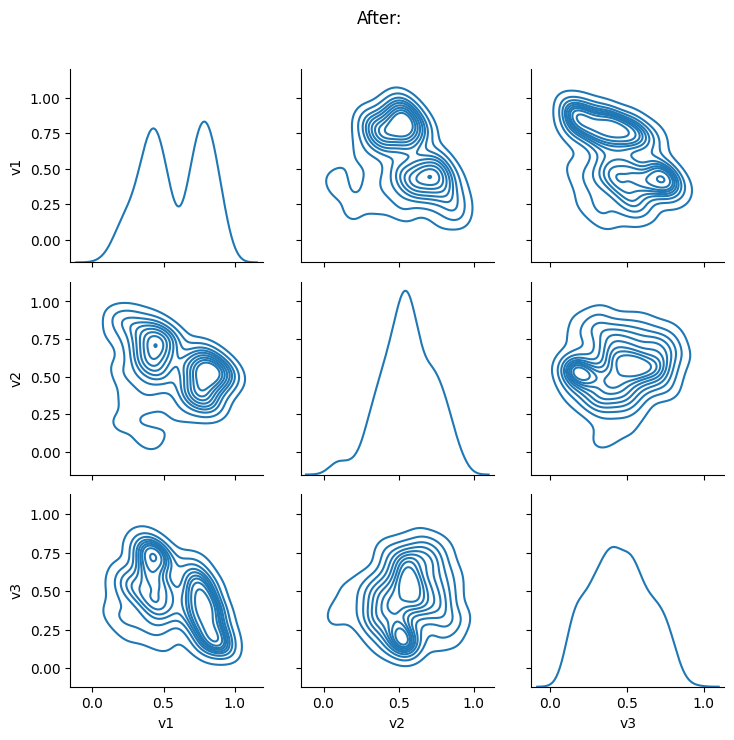

In [26]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

#5. AutoEncoder Model - Pytorch

In [39]:
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

In [29]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encode
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.ELU(),
            nn.Linear(8, 4),
            nn.ELU(),
            nn.Linear(4, 2),
            nn.ELU()
        )

        # Decode
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ELU(),
            nn.Linear(4, 8),
            nn.ELU(),
            nn.Linear(8, 16),
            nn.ELU(),
            nn.Linear(16, input_dim),
            nn.ELU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

##5.1 Initialization of the Autoencoder

In [111]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU
model = Autoencoder(input_dim).to(device)

criterian = nn.MSELoss() # MSE Loss function
optimizer = optim.Adam(model.parameters()) # Adam Model as the optimizer

##5.2 Tensor pytorch transformation

In [183]:
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
X_validate_tensor = torch.tensor(X_validate_transformed, dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(X_train_tensor,X_train_tensor),
    batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(
    TensorDataset(X_validate_tensor,X_validate_tensor),
    batch_size=BATCH_SIZE, shuffle=False)

##5.3 Training Autoencoder

In [184]:
for epoch in range(EPOCHS):
    model.train()

    for data in train_loader:
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # We set the zeros the gradients of retroprograti.
        outputs = model(inputs)
        loss = criterian(outputs, targets)
        loss.backward() # We compute the gradient Loss
        optimizer.step() # We upload the model coeficients

    # Validacion Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): # No gradient!
        for val_data in val_loader:
            val_inputs, val_targets = val_data
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterian(val_outputs, val_targets).item()

    val_loss /= len(val_loader) #The accumulated divided by total number

    print(f"""Epoch {epoch+1}/{EPOCHS}:
      Train. Loss: {loss.item():.4f} - Valid. Loss: {val_loss:.4f}""")

Epoch 1/100: 
      Train. Loss: 0.0105 - Valid. Loss: 0.0105
Epoch 2/100: 
      Train. Loss: 0.0104 - Valid. Loss: 0.0104
Epoch 3/100: 
      Train. Loss: 0.0105 - Valid. Loss: 0.0105
Epoch 4/100: 
      Train. Loss: 0.0100 - Valid. Loss: 0.0104
Epoch 5/100: 
      Train. Loss: 0.0106 - Valid. Loss: 0.0104
Epoch 6/100: 
      Train. Loss: 0.0106 - Valid. Loss: 0.0104
Epoch 7/100: 
      Train. Loss: 0.0098 - Valid. Loss: 0.0104
Epoch 8/100: 
      Train. Loss: 0.0108 - Valid. Loss: 0.0104
Epoch 9/100: 
      Train. Loss: 0.0105 - Valid. Loss: 0.0105
Epoch 10/100: 
      Train. Loss: 0.0105 - Valid. Loss: 0.0104
Epoch 11/100: 
      Train. Loss: 0.0107 - Valid. Loss: 0.0104
Epoch 12/100: 
      Train. Loss: 0.0102 - Valid. Loss: 0.0104
Epoch 13/100: 
      Train. Loss: 0.0103 - Valid. Loss: 0.0104
Epoch 14/100: 
      Train. Loss: 0.0103 - Valid. Loss: 0.0104
Epoch 15/100: 
      Train. Loss: 0.0104 - Valid. Loss: 0.0104
Epoch 16/100: 
      Train. Loss: 0.0106 - Valid. Loss: 0.0104
E

##5.4 Testing - Data

In [128]:
X_test_transformed = pipeline.transform(X_test)
X_test_tensor = torch.tensor(X_test_transformed,dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
  reconstructions = model(X_test_tensor)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


##5.5 Results

In [131]:
reconstructions_np = reconstructions.cpu().numpy() #We need a numpy not a tensor
mse = np.mean(np.power(X_test_transformed - reconstructions_np, 2), axis=1)

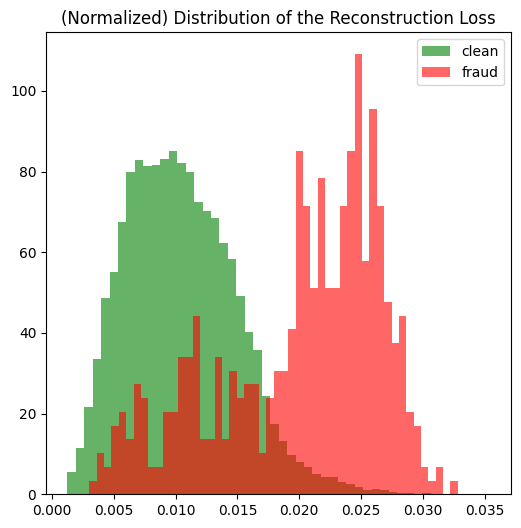

In [132]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

#6. Threshold

In [133]:
THRESHOLD = 3

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)

    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [134]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 646 outliers in a total of 84,807 transactions [0.76%].


#7. Classification

In [135]:
from sklearn.metrics import (confusion_matrix,
                             precision_recall_curve)

# Classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp,
 fn, tp) = cm.flatten()

In [136]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[83833   482]
 [  328   164]]

% of transactions labeled as fraud that were correct (precision): 164/(482+164) = 25.39%
% of fraudulent transactions were caught succesfully (recall):    164/(328+164) = 33.33%


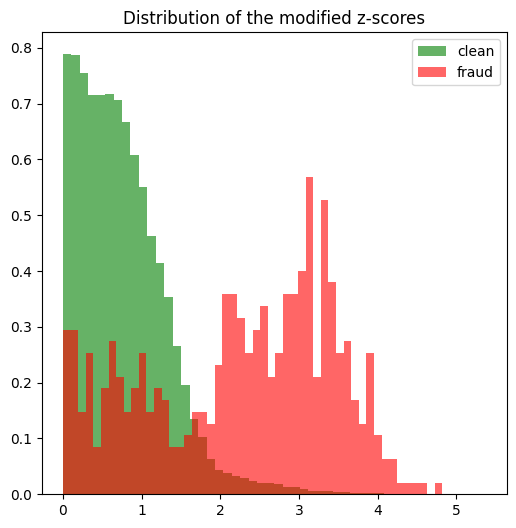

In [137]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()